In [39]:
pip install matplotlib scikit-learn seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [40]:
#Importação das bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import classification_report
import seaborn as sns

Análise Exploratória dos Dados

In [41]:
#Carregando o dataset

df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
#Informações estruturais
df.info()

In [ ]:
#Informações estatísticas numéricas
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


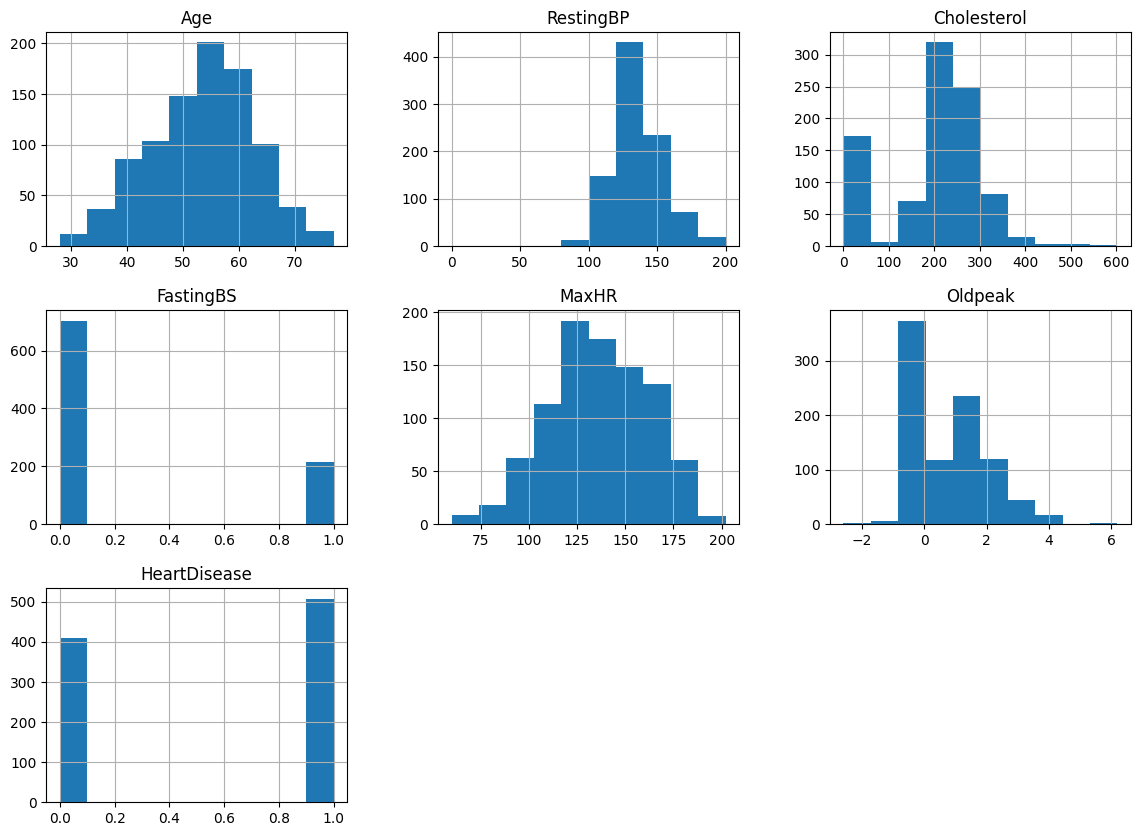

In [ ]:
#Distribuição de variáveis
df.hist(figsize=(14,10))
plt.show()

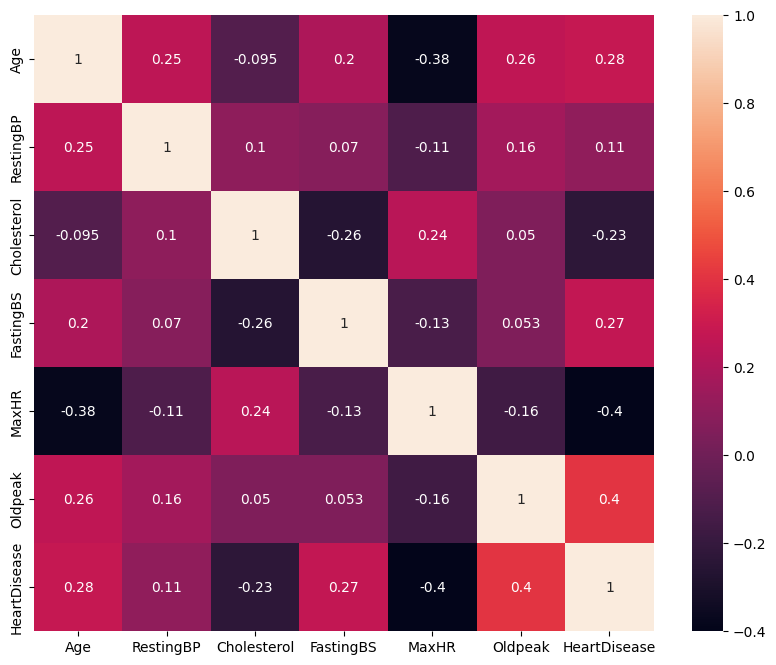

In [ ]:
#Matriz de correlação
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.show()

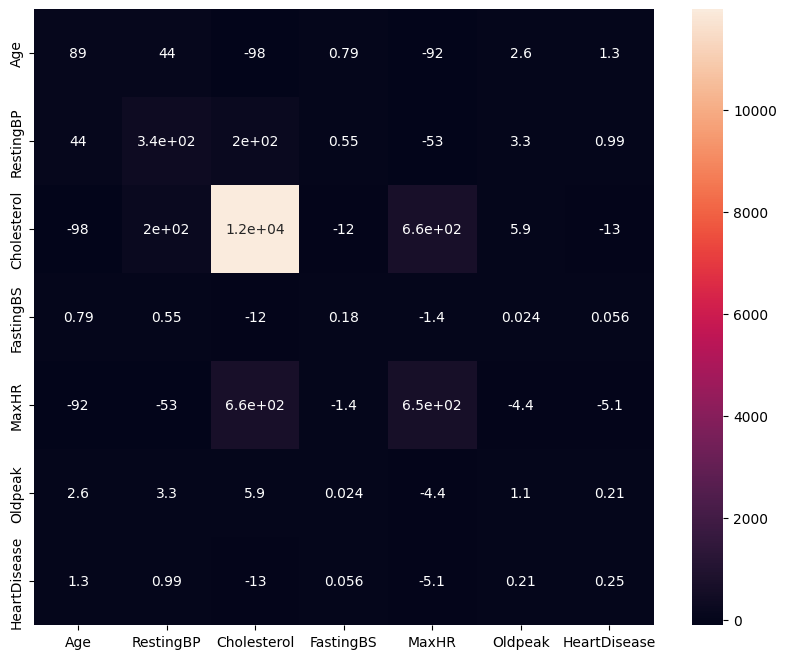

In [ ]:
#Matriz de covariância
plt.figure(figsize=(10,8))
sns.heatmap(df.cov(numeric_only=True), annot=True)
plt.show()

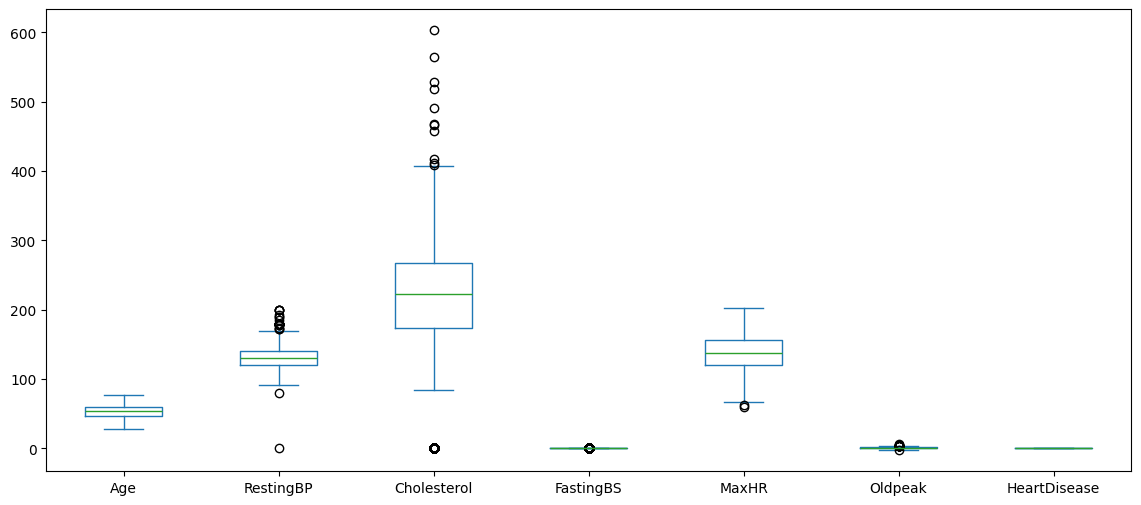

In [ ]:
#Detecção de outliers
df.plot(kind='box', figsize=(14,6))
plt.show()

Pré-processamento dos dados

In [ ]:
#Separação de features e target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']


In [ ]:
#Conversão de colunas não-numéricas para numéricas
X = pd.get_dummies(X, drop_first=True)

In [ ]:
#K-Fold Cross-Validation
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_index, test_index in kfold.split(X):
 X_train, X_test = X.iloc[train_index], X.iloc[test_index]
 y_train, y_test = y.iloc[train_index], y.iloc[test_index]
 folds.append((X_train, X_test, y_train, y_test))

In [ ]:
#Normalização e transformação
scaler = StandardScaler()
pt = PowerTransformer()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pt.fit_transform(X_train_scaled)
X_test_scaled = pt.transform(X_test_scaled)

In [ ]:
#Preparação para CNN de 1D
X_train_cnn = np.expand_dims(X_train_scaled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)


print('Formato treino CNN:', X_train_cnn.shape)
print('Formato teste CNN:', X_test_cnn.shape)

Formato treino CNN: (734, 15, 1)
Formato teste CNN: (184, 15, 1)
